In [ ]:
!pip install --upgrade tensorflow



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Attention,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


In [ ]:
df = pd.read_csv('train.csv',on_bad_lines='skip')


In [ ]:

X = df['comment_text'].fillna('').astype(str).tolist()

# To Ensure target values are numeric
for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Tokenize the text data and Vectorization
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)

print(X)
print(y)


[[    0     0     0 ...  4583  2273   985]
 [    0     0     0 ...   589  8377   182]
 [    0     0     0 ...     1   737   468]
 ...
 [    0     0     0 ...  3509 13675  4528]
 [    0     0     0 ...   151    34    11]
 [    0     0     0 ...  1627  2056    88]]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train stats:")
print(f"Min: {np.min(X_train)}, Max: {np.max(X_train)}, Mean: {np.mean(X_train)}")
print("y_train stats:")
print(f"Min: {np.min(y_train)}, Max: {np.max(y_train)}, Mean: {np.mean(y_train)}")

input_layer = Input(shape=(100,))
embedding = Embedding(input_dim=max_features, output_dim=128)(input_layer)
dropout1 = Dropout(rate=0.5)(embedding)
bilstm = Bidirectional(LSTM(units=128, return_sequences=True))(dropout1)
dropout2 = Dropout(rate=0.5)(bilstm)
attention = Attention()([dropout2, dropout2])
conv1d = Conv1D(filters=128, kernel_size=3, activation='relu')(attention)
dropout3 = Dropout(rate=0.5)(conv1d)
global_max_pooling = GlobalMaxPooling1D()(dropout3)
dense = Dense(units=256, activation='relu', kernel_regularizer='l2')(global_max_pooling)
dropout4 = Dropout(rate=0.5)(dense)
batch_norm = BatchNormalization()(dropout4)
output_layer = Dense(units=6, activation='sigmoid')(batch_norm)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")



X_train stats:
Min: 0, Max: 19999, Mean: 485.1310485993608
y_train stats:
Min: 0, Max: 1, Mean: 0.0365879133504627
Epoch 1/10
3192/3192 [==============================] - 2047s 639ms/step - loss: 0.3793 - accuracy: 0.6394 - val_loss: 0.0808 - val_accuracy: 0.9943 - lr: 1.0000e-04
Epoch 2/10
3192/3192 [==============================] - 2011s 630ms/step - loss: 0.0626 - accuracy: 0.8979 - val_loss: 0.0730 - val_accuracy: 0.9943 - lr: 1.0000e-04
Epoch 3/10
3192/3192 [==============================] - 2054s 643ms/step - loss: 0.0554 - accuracy: 0.9538 - val_loss: 0.0739 - val_accuracy: 0.9943 - lr: 1.0000e-04
Epoch 4/10
3192/3192 [==============================] - 2077s 651ms/step - loss: 0.0523 - accuracy: 0.9640 - val_loss: 0.0775 - val_accuracy: 0.9943 - lr: 1.0000e-04
Epoch 5/10
3192/3192 [==============================] - 2065s 647ms/step - loss: 0.0481 - accuracy: 0.9685 - val_loss: 0.0717 - val_accuracy: 0.9943 - lr: 2.0000e-05
Epoch 6/10
3192/3192 [==============================] -

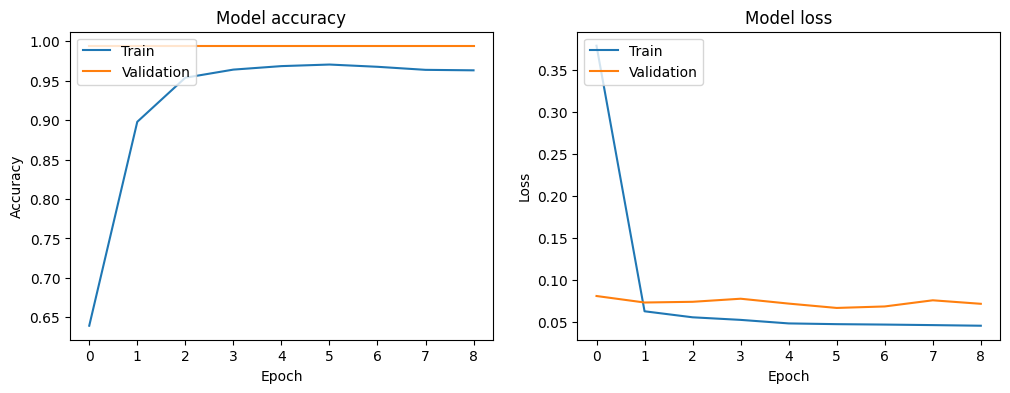

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [ ]:
def predict_toxicity(custom_comments):
    sequences = tokenizer.texts_to_sequences(custom_comments)
    padded_sequences = pad_sequences(sequences, maxlen=100)

    predictions = model.predict(padded_sequences)

    for i, comment in enumerate(custom_comments):
        print(f"\nComment: {comment}")
        print("Predictions:")
        print(f"  Toxic: {predictions[i][0]:.4f}")
        print(f"  Severe Toxic: {predictions[i][1]:.4f}")
        print(f"  Obscene: {predictions[i][2]:.4f}")
        print(f"  Threat: {predictions[i][3]:.4f}")
        print(f"  Insult: {predictions[i][4]:.4f}")
        print(f"  Identity Hate: {predictions[i][5]:.4f}")

In [ ]:
custom_comments = [
    "You are a terrible person and deserve to be punished.",
    "You are the worst scum on this planet, I hope you suffer.",
    "You are just genius of a person.",
    "You are too good to this world.",
    "You are a complete idiot and an absolute waste of space.",
    "We hate your soo much.",
    "f*ck you badly"
]

In [ ]:
predict_toxicity(custom_comments)

1/1 [==============================] - 0s 90ms/step

Comment: You are a terrible person and deserve to be punished.
Predictions:
  Toxic: 0.5560
  Severe Toxic: 0.0090
  Obscene: 0.1138
  Threat: 0.0085
  Insult: 0.1523
  Identity Hate: 0.0245

Comment: You are the worst scum on this planet, I hope you suffer.
Predictions:
  Toxic: 0.8872
  Severe Toxic: 0.0300
  Obscene: 0.4534
  Threat: 0.0185
  Insult: 0.4249
  Identity Hate: 0.0572

Comment: You are just genius of a person.
Predictions:
  Toxic: 0.1730
  Severe Toxic: 0.0029
  Obscene: 0.0269
  Threat: 0.0027
  Insult: 0.0341
  Identity Hate: 0.0067

Comment: You are too good to this world.
Predictions:
  Toxic: 0.1852
  Severe Toxic: 0.0031
  Obscene: 0.0288
  Threat: 0.0029
  Insult: 0.0367
  Identity Hate: 0.0071

Comment: You are a complete idiot and an absolute waste of space.
Predictions:
  Toxic: 0.9026
  Severe Toxic: 0.0337
  Obscene: 0.4972
  Threat: 0.0196
  Insult: 0.4540
  Identity Hate: 0.0605

Comment: We hate your s

In [ ]:
pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/saved_model/model1.h5')

In [ ]:
from tensorflow.keras.models import load_model
import pickle

with open('/content/drive/MyDrive/saved_model/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)


In [ ]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gradio as gr

model = load_model('/content/drive/MyDrive/saved_model/model1.h5')

with open('/content/drive/MyDrive/saved_model/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

def predict_toxicity(comment):

    sequences = tokenizer.texts_to_sequences([comment])
    padded_sequences = pad_sequences(sequences, maxlen=100)

    predictions = model.predict(padded_sequences)[0]

    result = {
        "Comment": comment,
        "Toxic": predictions[0],
        "Severe Toxic": predictions[1],
        "Obscene": predictions[2],
        "Threat": predictions[3],
        "Insult": predictions[4],
        "Identity Hate": predictions[5]
    }
    return result["Toxic"], result["Severe Toxic"], result["Obscene"], result["Threat"], result["Insult"], result["Identity Hate"]

interface = gr.Interface(
    fn=predict_toxicity,
    inputs=gr.Textbox(lines=2, placeholder="Enter comment here...", label="Comment"),
    outputs=[
        gr.Textbox(label="Toxic"),
        gr.Textbox(label="Severe Toxic"),
        gr.Textbox(label="Obscene"),
        gr.Textbox(label="Threat"),
        gr.Textbox(label="Insult"),
        gr.Textbox(label="Identity Hate")
    ],
    examples=[
        ["You are a terrible person and deserve to be punished."],
        ["You are the worst scum on this planet, I hope you suffer."],
        ["You are just a gem of a person."],
        ["You are too good to this world."],
        ["You are a complete idiot and an absolute waste of space."],
        ["We hate you so much."],
        ["F*ck you badly"]

    ]
)

interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://83d5b08c19415a26b5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
